# **Used Car Price Predictor Notebook**

### import required libraries

In [1]:
# used for data manipulation and wrangling
import pandas as pd 
import numpy as np
from pandasql import sqldf
# used for splitting the data into Training and Evaluation Datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
# used for creating the actual model
from sklearn.tree import DecisionTreeRegressor
# used for conducting Exploratory Data Analysis (EDA)
import plotly.express as px

from warnings import filterwarnings
filterwarnings('ignore')

## **MLOps Phase 1: Data Collection**
#### **Step 1: Extract Training Data from Parquet File**

In [2]:
# read parquet file into DataFrame
training_data = pd.read_parquet('raw_car_listings.parquet', engine='pyarrow')

# preview DataFrame
training_data

page_num                   vin                           header   
0             34  VINWBSDE9348YBZ94444                      2000 BMW M5  \
2             35  VINWBSCK9348YLC93243                      2000 BMW Z3   
4             20  VINWBSDE93421BZ97782                      2001 BMW M5   
7             30  VINWBSBL93403JR22861                      2003 BMW M3   
9             18  VIN5UXFA13594LU36403                      2004 BMW X5   
...          ...                   ...                              ...   
629262         2  VINWDCTG4GB7GJ220872  Sponsored2016 Mercedes-Benz GLA   
629263         3  VIN1G1JC5SH6C4112061             2012 Chevrolet Sonic   
629265       126  VINJM1CW2BL2C0135032                2012 Mazda Mazda5   
629266       126  VINJM1CW2BLXE0173496                2014 Mazda Mazda5   
629267       112  VINJN1CV6EL0EM130822                2014 INFINITI Q60   

                       trim           price        mileage   
0                     Sedan         $21,950  185,123 miles  \
2                M Roadster         $18,995   97,190 miles   
4                     Sedan         $24,950  154,671 miles   
7                     Coupe  $27,900$22,900  111,370 miles   
9                  3.0i AWD          $5,500  199,861 miles   
...                     ...             ...            ...   
629262       GLA 250 4MATIC  $23,409$23,398   35,602 miles   
629263      LT 2LT Sedan AT          $8,191  130,163 miles   
629265      Sport Automatic         $14,599   75,664 miles   
629266      Sport Automatic         $16,998   58,600 miles   
629267  Coupe AWD Automatic         $24,998   43,513 miles   

                          location                           colors   
0             471 mi - Phoenix, AZ   Black exterior, Brown interior  \
2       27 mi - Salt Lake City, UT  Silver exterior, Black interior   
4             462 mi - Phoenix, AZ    Blue exterior, Black interior   
7             474 mi - Phoenix, AZ   Black exterior, Black interior   
9              348 mi - Denver, CO    Gray exterior, Black interior   
...                            ...                              ...   
629262      1,900 mi - Orlando, FL   White exterior, Brown interior   
629263     349 mi - Ft Collins, CO     Red exterior, Black interior   
629265      513 mi - Roseville, CA  Copper exterior, Beige interior   
629266         591 mi - Oxnard, CA  Silver exterior, Black interior   
629267     1,821 mi - Sterling, VA    Black exterior, Gray interior   

                                            condition  
0                  1 accident, 4 Owners, Personal use  
2                  1 accident, 4 Owners, Personal use  
4       No accidents reported, 5 Owners, Personal use  
7                 2 accidents, 4 Owners, Personal use  
9          No accidents reported, 7 Owners, Fleet use  
...                                               ...  
629262  No accidents reported, 5 Owners, Personal use  
629263  No accidents reported, 5 Owners, Personal use  
629265  No accidents reported, 5 Owners, Personal use  
629266  No accidents reported, 5 Owners, Personal use  
629267  No accidents reported, 5 Owners, Personal use  

[78510 rows x 9 columns]

#### **Step 2: Preview the Dataset's Schema**

In [3]:
with open("raw_car_listings_schema.txt", "r") as file:
    for line in file:
        print(line)

RAW TRAINING DATA SCHEMA



page_num - the page number of which the listing was extracted.

vin - Vehicle Identification Number. This is used to uniquely identify the vehicle and is used in conjunction with other fields to unqiuely identify each listing.

header - main title for the listing. This include information on the vehicle's year, make, and model.

trim - trim level of the vehicle specified.

price - price of the vehicle listed. Some fields include a recommended price.

mileage - number of miles on the vehicle's odometer.

location - where the listing was posted.

colors - description of the exterior and interior of the vehicle.

condition - includes information related to the number of accidents, number of owners, and whether or not the vehicle was used for personal or fleet use.


## **MLOPs Phase 2: Data Ingestion**
#### For the purposes of this tutorial, we will not be ingesting data. However, in an organizational setting, you'll use an ingestion framework, such as Apache Airflow, Apache Spark, or Apache Kafka, to collect data into a Data Lake to create a curated Training Dataset.

## **MLOPs Phase 3: Data Storage**
#### Since we already extracted this data was previously extracted from BigQuery, this phase has already been completed. Typically, you'll use a Cloud Storage Bucket (e.g., AWS S3, Google Cloud Storage) to store all data to be used in ML applications.

## **MLOPs Phase 4: Data Pipeline (Preparation and Wrangling)**
#### **Step 1: Use Intuition to Remove Irrelevant Features**

In [4]:
training_data.drop(columns=['page_num', 'vin'], inplace=True)
training_data

header                 trim           price   
0                           2000 BMW M5                Sedan         $21,950  \
2                           2000 BMW Z3           M Roadster         $18,995   
4                           2001 BMW M5                Sedan         $24,950   
7                           2003 BMW M3                Coupe  $27,900$22,900   
9                           2004 BMW X5             3.0i AWD          $5,500   
...                                 ...                  ...             ...   
629262  Sponsored2016 Mercedes-Benz GLA       GLA 250 4MATIC  $23,409$23,398   
629263             2012 Chevrolet Sonic      LT 2LT Sedan AT          $8,191   
629265                2012 Mazda Mazda5      Sport Automatic         $14,599   
629266                2014 Mazda Mazda5      Sport Automatic         $16,998   
629267                2014 INFINITI Q60  Coupe AWD Automatic         $24,998   

              mileage                    location   
0       185,123 miles        471 mi - Phoenix, AZ  \
2        97,190 miles  27 mi - Salt Lake City, UT   
4       154,671 miles        462 mi - Phoenix, AZ   
7       111,370 miles        474 mi - Phoenix, AZ   
9       199,861 miles         348 mi - Denver, CO   
...               ...                         ...   
629262   35,602 miles      1,900 mi - Orlando, FL   
629263  130,163 miles     349 mi - Ft Collins, CO   
629265   75,664 miles      513 mi - Roseville, CA   
629266   58,600 miles         591 mi - Oxnard, CA   
629267   43,513 miles     1,821 mi - Sterling, VA   

                                 colors   
0        Black exterior, Brown interior  \
2       Silver exterior, Black interior   
4         Blue exterior, Black interior   
7        Black exterior, Black interior   
9         Gray exterior, Black interior   
...                                 ...   
629262   White exterior, Brown interior   
629263     Red exterior, Black interior   
629265  Copper exterior, Beige interior   
629266  Silver exterior, Black interior   
629267    Black exterior, Gray interior   

                                            condition  
0                  1 accident, 4 Owners, Personal use  
2                  1 accident, 4 Owners, Personal use  
4       No accidents reported, 5 Owners, Personal use  
7                 2 accidents, 4 Owners, Personal use  
9          No accidents reported, 7 Owners, Fleet use  
...                                               ...  
629262  No accidents reported, 5 Owners, Personal use  
629263  No accidents reported, 5 Owners, Personal use  
629265  No accidents reported, 5 Owners, Personal use  
629266  No accidents reported, 5 Owners, Personal use  
629267  No accidents reported, 5 Owners, Personal use  

[78510 rows x 7 columns]

#### **Step 2: Remove Data with Troublesome Headers (Foreshadowing)**

In [5]:
# remove all listings will a make that contains a space
training_data = training_data[~training_data['header'].str.contains('Land Rover')]
training_data = training_data[~training_data['header'].str.contains('Alfa Romeo')]
training_data = training_data[~training_data['header'].str.contains('Aston Martin')]
training_data.reset_index(drop=True, inplace=True)
training_data

header                 trim           price   
0                          2000 BMW M5                Sedan         $21,950  \
1                          2000 BMW Z3           M Roadster         $18,995   
2                          2001 BMW M5                Sedan         $24,950   
3                          2003 BMW M3                Coupe  $27,900$22,900   
4                          2004 BMW X5             3.0i AWD          $5,500   
...                                ...                  ...             ...   
78313  Sponsored2016 Mercedes-Benz GLA       GLA 250 4MATIC  $23,409$23,398   
78314             2012 Chevrolet Sonic      LT 2LT Sedan AT          $8,191   
78315                2012 Mazda Mazda5      Sport Automatic         $14,599   
78316                2014 Mazda Mazda5      Sport Automatic         $16,998   
78317                2014 INFINITI Q60  Coupe AWD Automatic         $24,998   

             mileage                    location   
0      185,123 miles        471 mi - Phoenix, AZ  \
1       97,190 miles  27 mi - Salt Lake City, UT   
2      154,671 miles        462 mi - Phoenix, AZ   
3      111,370 miles        474 mi - Phoenix, AZ   
4      199,861 miles         348 mi - Denver, CO   
...              ...                         ...   
78313   35,602 miles      1,900 mi - Orlando, FL   
78314  130,163 miles     349 mi - Ft Collins, CO   
78315   75,664 miles      513 mi - Roseville, CA   
78316   58,600 miles         591 mi - Oxnard, CA   
78317   43,513 miles     1,821 mi - Sterling, VA   

                                colors   
0       Black exterior, Brown interior  \
1      Silver exterior, Black interior   
2        Blue exterior, Black interior   
3       Black exterior, Black interior   
4        Gray exterior, Black interior   
...                                ...   
78313   White exterior, Brown interior   
78314     Red exterior, Black interior   
78315  Copper exterior, Beige interior   
78316  Silver exterior, Black interior   
78317    Black exterior, Gray interior   

                                           condition  
0                 1 accident, 4 Owners, Personal use  
1                 1 accident, 4 Owners, Personal use  
2      No accidents reported, 5 Owners, Personal use  
3                2 accidents, 4 Owners, Personal use  
4         No accidents reported, 7 Owners, Fleet use  
...                                              ...  
78313  No accidents reported, 5 Owners, Personal use  
78314  No accidents reported, 5 Owners, Personal use  
78315  No accidents reported, 5 Owners, Personal use  
78316  No accidents reported, 5 Owners, Personal use  
78317  No accidents reported, 5 Owners, Personal use  

[78318 rows x 7 columns]

#### **Step 4: Split "header" Column into "model_year", "make", and "model" Columns. Reorder Columns**

In [6]:
# instantiate variable to hold temp splits
new_cols = training_data['header'].str.split(n=2, pat=' ', expand=True)
# create new columns based on split indices
training_data['model_year'] = new_cols[0]
training_data['make'] = new_cols[1]
training_data['model'] = new_cols[2]
# clean "model_year" column from unwanted strings
training_data['model_year'] = training_data['model_year'].str.replace('Sponsored', '')
training_data['model_year'] = training_data['model_year'].str.strip()
# convert "model_year" column to an integer
training_data['model_year'] = training_data['model_year'].astype(int)
# reorder columns
training_data = training_data[['price', 'model_year', 'make', 'model', 'trim', 'mileage', 'colors', 'condition', 'location']]
training_data

price  model_year           make   model                 trim   
0             $21,950        2000            BMW      M5                Sedan  \
1             $18,995        2000            BMW      Z3           M Roadster   
2             $24,950        2001            BMW      M5                Sedan   
3      $27,900$22,900        2003            BMW      M3                Coupe   
4              $5,500        2004            BMW      X5             3.0i AWD   
...               ...         ...            ...     ...                  ...   
78313  $23,409$23,398        2016  Mercedes-Benz     GLA       GLA 250 4MATIC   
78314          $8,191        2012      Chevrolet   Sonic      LT 2LT Sedan AT   
78315         $14,599        2012          Mazda  Mazda5      Sport Automatic   
78316         $16,998        2014          Mazda  Mazda5      Sport Automatic   
78317         $24,998        2014       INFINITI     Q60  Coupe AWD Automatic   

             mileage                           colors   
0      185,123 miles   Black exterior, Brown interior  \
1       97,190 miles  Silver exterior, Black interior   
2      154,671 miles    Blue exterior, Black interior   
3      111,370 miles   Black exterior, Black interior   
4      199,861 miles    Gray exterior, Black interior   
...              ...                              ...   
78313   35,602 miles   White exterior, Brown interior   
78314  130,163 miles     Red exterior, Black interior   
78315   75,664 miles  Copper exterior, Beige interior   
78316   58,600 miles  Silver exterior, Black interior   
78317   43,513 miles    Black exterior, Gray interior   

                                           condition   
0                 1 accident, 4 Owners, Personal use  \
1                 1 accident, 4 Owners, Personal use   
2      No accidents reported, 5 Owners, Personal use   
3                2 accidents, 4 Owners, Personal use   
4         No accidents reported, 7 Owners, Fleet use   
...                                              ...   
78313  No accidents reported, 5 Owners, Personal use   
78314  No accidents reported, 5 Owners, Personal use   
78315  No accidents reported, 5 Owners, Personal use   
78316  No accidents reported, 5 Owners, Personal use   
78317  No accidents reported, 5 Owners, Personal use   

                         location  
0            471 mi - Phoenix, AZ  
1      27 mi - Salt Lake City, UT  
2            462 mi - Phoenix, AZ  
3            474 mi - Phoenix, AZ  
4             348 mi - Denver, CO  
...                           ...  
78313      1,900 mi - Orlando, FL  
78314     349 mi - Ft Collins, CO  
78315      513 mi - Roseville, CA  
78316         591 mi - Oxnard, CA  
78317     1,821 mi - Sterling, VA  

[78318 rows x 9 columns]

#### **Step 5: Clean "price" Column and Convert to Integer**

In [7]:
# instantiate variable to hold temp split values
new_cols = training_data['price'].str.split(pat='$', n=2, expand=True)
# create new column based on split indices
training_data['price'] = new_cols[1]
# clean "price" column
training_data['price'] = training_data['price'].str.replace(',', '')
training_data['price'] = training_data['price'].str.strip()
# convert "price" column to an integer
training_data['price'] = training_data['price'].astype(int)
training_data

price  model_year           make   model                 trim   
0      21950        2000            BMW      M5                Sedan  \
1      18995        2000            BMW      Z3           M Roadster   
2      24950        2001            BMW      M5                Sedan   
3      27900        2003            BMW      M3                Coupe   
4       5500        2004            BMW      X5             3.0i AWD   
...      ...         ...            ...     ...                  ...   
78313  23409        2016  Mercedes-Benz     GLA       GLA 250 4MATIC   
78314   8191        2012      Chevrolet   Sonic      LT 2LT Sedan AT   
78315  14599        2012          Mazda  Mazda5      Sport Automatic   
78316  16998        2014          Mazda  Mazda5      Sport Automatic   
78317  24998        2014       INFINITI     Q60  Coupe AWD Automatic   

             mileage                           colors   
0      185,123 miles   Black exterior, Brown interior  \
1       97,190 miles  Silver exterior, Black interior   
2      154,671 miles    Blue exterior, Black interior   
3      111,370 miles   Black exterior, Black interior   
4      199,861 miles    Gray exterior, Black interior   
...              ...                              ...   
78313   35,602 miles   White exterior, Brown interior   
78314  130,163 miles     Red exterior, Black interior   
78315   75,664 miles  Copper exterior, Beige interior   
78316   58,600 miles  Silver exterior, Black interior   
78317   43,513 miles    Black exterior, Gray interior   

                                           condition   
0                 1 accident, 4 Owners, Personal use  \
1                 1 accident, 4 Owners, Personal use   
2      No accidents reported, 5 Owners, Personal use   
3                2 accidents, 4 Owners, Personal use   
4         No accidents reported, 7 Owners, Fleet use   
...                                              ...   
78313  No accidents reported, 5 Owners, Personal use   
78314  No accidents reported, 5 Owners, Personal use   
78315  No accidents reported, 5 Owners, Personal use   
78316  No accidents reported, 5 Owners, Personal use   
78317  No accidents reported, 5 Owners, Personal use   

                         location  
0            471 mi - Phoenix, AZ  
1      27 mi - Salt Lake City, UT  
2            462 mi - Phoenix, AZ  
3            474 mi - Phoenix, AZ  
4             348 mi - Denver, CO  
...                           ...  
78313      1,900 mi - Orlando, FL  
78314     349 mi - Ft Collins, CO  
78315      513 mi - Roseville, CA  
78316         591 mi - Oxnard, CA  
78317     1,821 mi - Sterling, VA  

[78318 rows x 9 columns]

#### **Step 6: Clean "mileage" Column and Convert to Integer**

In [8]:
# clean "mileage" from unwanted strings
training_data['mileage'] = training_data['mileage'].str.replace(',', '')
training_data['mileage'] = training_data['mileage'].str.replace(' miles', '')
training_data['mileage'] = training_data['mileage'].str.strip()
# convert "mileage" column to integer
training_data['mileage'] = training_data['mileage'].astype(int)
training_data

price  model_year           make   model                 trim  mileage   
0      21950        2000            BMW      M5                Sedan   185123  \
1      18995        2000            BMW      Z3           M Roadster    97190   
2      24950        2001            BMW      M5                Sedan   154671   
3      27900        2003            BMW      M3                Coupe   111370   
4       5500        2004            BMW      X5             3.0i AWD   199861   
...      ...         ...            ...     ...                  ...      ...   
78313  23409        2016  Mercedes-Benz     GLA       GLA 250 4MATIC    35602   
78314   8191        2012      Chevrolet   Sonic      LT 2LT Sedan AT   130163   
78315  14599        2012          Mazda  Mazda5      Sport Automatic    75664   
78316  16998        2014          Mazda  Mazda5      Sport Automatic    58600   
78317  24998        2014       INFINITI     Q60  Coupe AWD Automatic    43513   

                                colors   
0       Black exterior, Brown interior  \
1      Silver exterior, Black interior   
2        Blue exterior, Black interior   
3       Black exterior, Black interior   
4        Gray exterior, Black interior   
...                                ...   
78313   White exterior, Brown interior   
78314     Red exterior, Black interior   
78315  Copper exterior, Beige interior   
78316  Silver exterior, Black interior   
78317    Black exterior, Gray interior   

                                           condition   
0                 1 accident, 4 Owners, Personal use  \
1                 1 accident, 4 Owners, Personal use   
2      No accidents reported, 5 Owners, Personal use   
3                2 accidents, 4 Owners, Personal use   
4         No accidents reported, 7 Owners, Fleet use   
...                                              ...   
78313  No accidents reported, 5 Owners, Personal use   
78314  No accidents reported, 5 Owners, Personal use   
78315  No accidents reported, 5 Owners, Personal use   
78316  No accidents reported, 5 Owners, Personal use   
78317  No accidents reported, 5 Owners, Personal use   

                         location  
0            471 mi - Phoenix, AZ  
1      27 mi - Salt Lake City, UT  
2            462 mi - Phoenix, AZ  
3            474 mi - Phoenix, AZ  
4             348 mi - Denver, CO  
...                           ...  
78313      1,900 mi - Orlando, FL  
78314     349 mi - Ft Collins, CO  
78315      513 mi - Roseville, CA  
78316         591 mi - Oxnard, CA  
78317     1,821 mi - Sterling, VA  

[78318 rows x 9 columns]

#### **Step 7: Split "colors" Column into "exterior_color" and "interior_color" Columns. Reorder Columns**

In [9]:
# instantiate variable to hold temp split values
new_cols = training_data['colors'].str.split(pat=',', n=2, expand=True)
# create new columns based on string indices
training_data['exterior_color'] = new_cols[0]
training_data['interior_color'] = new_cols[1]
# remove unwanted strings from new columns
training_data['exterior_color'] = training_data['exterior_color'].str.replace(' exterior', '')
training_data['interior_color'] = training_data['interior_color'].str.replace(' interior', '')
# reorder columns
training_data = training_data[['price', 'model_year', 'make', 'model', 'trim', 'mileage', 'exterior_color', 'interior_color', 'condition', 'location']]

training_data

price  model_year           make   model                 trim  mileage   
0      21950        2000            BMW      M5                Sedan   185123  \
1      18995        2000            BMW      Z3           M Roadster    97190   
2      24950        2001            BMW      M5                Sedan   154671   
3      27900        2003            BMW      M3                Coupe   111370   
4       5500        2004            BMW      X5             3.0i AWD   199861   
...      ...         ...            ...     ...                  ...      ...   
78313  23409        2016  Mercedes-Benz     GLA       GLA 250 4MATIC    35602   
78314   8191        2012      Chevrolet   Sonic      LT 2LT Sedan AT   130163   
78315  14599        2012          Mazda  Mazda5      Sport Automatic    75664   
78316  16998        2014          Mazda  Mazda5      Sport Automatic    58600   
78317  24998        2014       INFINITI     Q60  Coupe AWD Automatic    43513   

      exterior_color interior_color   
0              Black          Brown  \
1             Silver          Black   
2               Blue          Black   
3              Black          Black   
4               Gray          Black   
...              ...            ...   
78313          White          Brown   
78314            Red          Black   
78315         Copper          Beige   
78316         Silver          Black   
78317          Black           Gray   

                                           condition   
0                 1 accident, 4 Owners, Personal use  \
1                 1 accident, 4 Owners, Personal use   
2      No accidents reported, 5 Owners, Personal use   
3                2 accidents, 4 Owners, Personal use   
4         No accidents reported, 7 Owners, Fleet use   
...                                              ...   
78313  No accidents reported, 5 Owners, Personal use   
78314  No accidents reported, 5 Owners, Personal use   
78315  No accidents reported, 5 Owners, Personal use   
78316  No accidents reported, 5 Owners, Personal use   
78317  No accidents reported, 5 Owners, Personal use   

                         location  
0            471 mi - Phoenix, AZ  
1      27 mi - Salt Lake City, UT  
2            462 mi - Phoenix, AZ  
3            474 mi - Phoenix, AZ  
4             348 mi - Denver, CO  
...                           ...  
78313      1,900 mi - Orlando, FL  
78314     349 mi - Ft Collins, CO  
78315      513 mi - Roseville, CA  
78316         591 mi - Oxnard, CA  
78317     1,821 mi - Sterling, VA  

[78318 rows x 10 columns]

#### **Step 8: Split "condition" Column into "num_accidents", "num_owners", and "usage_type". Reorder Columns.**

In [10]:
# instantiate variable to hold temp split values
new_cols = training_data['condition'].str.split(pat=',', n=3, expand=True)
# create new columns based on split indices
training_data['num_accidents'] = new_cols[0]
training_data['num_owners'] = new_cols[1]
training_data['usage_type'] = new_cols[2]
# clean "num_accidents" column from unwanted strings
training_data['num_accidents'] = np.where(training_data['num_accidents'].str.contains('No'), 0, training_data['num_accidents'])
training_data['num_accidents'] = training_data['num_accidents'].str.replace('accidents', '')
training_data['num_accidents'] = training_data['num_accidents'].str.replace('accident', '')
training_data['num_accidents'] = training_data['num_accidents'].str.strip()
training_data['num_accidents'].fillna(0, inplace=True)
# convert "num_accidents" column to integer
training_data['num_accidents'] = training_data['num_accidents'].astype(int)
# clean "num_owners" column from unwanted strings
training_data['num_owners'] = training_data['num_owners'].str.replace('Owner', '')
training_data['num_owners'] = training_data['num_owners'].str.replace('Owners', '')
training_data['num_owners'] = training_data['num_owners'].str.replace('s', '')
training_data = training_data[~training_data['num_owners'].str.contains('P')]
training_data = training_data[~training_data['num_owners'].str.contains('F')]
training_data['num_owners'] = training_data['num_owners'].str.strip()
# convert "num_owners" column to integer
training_data['num_owners'] = training_data['num_owners'].astype(int)
# clean the "usage_type" column from unwanted strings
training_data['usage_type'] = training_data['usage_type'].str.replace(' use', '')
# reorder columns
training_data = training_data[['price', 'model_year', 'make', 'model', 'trim', 'mileage', 'exterior_color', 'interior_color', 'num_accidents', 'num_owners', 'usage_type', 'location']]

training_data

price  model_year           make   model                 trim  mileage   
0      21950        2000            BMW      M5                Sedan   185123  \
1      18995        2000            BMW      Z3           M Roadster    97190   
2      24950        2001            BMW      M5                Sedan   154671   
3      27900        2003            BMW      M3                Coupe   111370   
4       5500        2004            BMW      X5             3.0i AWD   199861   
...      ...         ...            ...     ...                  ...      ...   
78313  23409        2016  Mercedes-Benz     GLA       GLA 250 4MATIC    35602   
78314   8191        2012      Chevrolet   Sonic      LT 2LT Sedan AT   130163   
78315  14599        2012          Mazda  Mazda5      Sport Automatic    75664   
78316  16998        2014          Mazda  Mazda5      Sport Automatic    58600   
78317  24998        2014       INFINITI     Q60  Coupe AWD Automatic    43513   

      exterior_color interior_color  num_accidents  num_owners usage_type   
0              Black          Brown              1           4   Personal  \
1             Silver          Black              1           4   Personal   
2               Blue          Black              0           5   Personal   
3              Black          Black              2           4   Personal   
4               Gray          Black              0           7      Fleet   
...              ...            ...            ...         ...        ...   
78313          White          Brown              0           5   Personal   
78314            Red          Black              0           5   Personal   
78315         Copper          Beige              0           5   Personal   
78316         Silver          Black              0           5   Personal   
78317          Black           Gray              0           5   Personal   

                         location  
0            471 mi - Phoenix, AZ  
1      27 mi - Salt Lake City, UT  
2            462 mi - Phoenix, AZ  
3            474 mi - Phoenix, AZ  
4             348 mi - Denver, CO  
...                           ...  
78313      1,900 mi - Orlando, FL  
78314     349 mi - Ft Collins, CO  
78315      513 mi - Roseville, CA  
78316         591 mi - Oxnard, CA  
78317     1,821 mi - Sterling, VA  

[78308 rows x 12 columns]

#### **Step 9: Split "location" Column into "city" and "state" Columns. Reorder Columns.**

In [11]:
# instantiate variable to fold temp split values
new_cols = training_data['location'].str.split(pat=', ', n=2, expand=True)
# create new columns based on split indices
training_data['city'] = new_cols[0]
training_data['state'] = new_cols[1]
# clean "city" column from unwanted strings
training_data['city'] = np.where(training_data['city'].str.contains('Online'), 'Online', training_data['city'])
training_data['city'] = training_data['city'].str.replace(' mi - ', '')
training_data['city'] = training_data['city'].str.replace('\d+', '', regex=True)
# clean "state" column from unwanted strings
training_data['city'] = training_data['city'].str.strip()
training_data['city'] = training_data['city'].str.replace(',', '')
training_data['city'] = training_data['city'].str.replace('.', '')
training_data['state'] = training_data['state'].str.strip()
# reorder columns
clean_listings = training_data[['price', 'model_year', 'make', 'model', 'trim', 'mileage', 'exterior_color', 'interior_color', 'num_accidents', 'num_owners', 'usage_type', 'city', 'state']]

clean_listings

price  model_year           make   model                 trim  mileage   
0      21950        2000            BMW      M5                Sedan   185123  \
1      18995        2000            BMW      Z3           M Roadster    97190   
2      24950        2001            BMW      M5                Sedan   154671   
3      27900        2003            BMW      M3                Coupe   111370   
4       5500        2004            BMW      X5             3.0i AWD   199861   
...      ...         ...            ...     ...                  ...      ...   
78313  23409        2016  Mercedes-Benz     GLA       GLA 250 4MATIC    35602   
78314   8191        2012      Chevrolet   Sonic      LT 2LT Sedan AT   130163   
78315  14599        2012          Mazda  Mazda5      Sport Automatic    75664   
78316  16998        2014          Mazda  Mazda5      Sport Automatic    58600   
78317  24998        2014       INFINITI     Q60  Coupe AWD Automatic    43513   

      exterior_color interior_color  num_accidents  num_owners usage_type   
0              Black          Brown              1           4   Personal  \
1             Silver          Black              1           4   Personal   
2               Blue          Black              0           5   Personal   
3              Black          Black              2           4   Personal   
4               Gray          Black              0           7      Fleet   
...              ...            ...            ...         ...        ...   
78313          White          Brown              0           5   Personal   
78314            Red          Black              0           5   Personal   
78315         Copper          Beige              0           5   Personal   
78316         Silver          Black              0           5   Personal   
78317          Black           Gray              0           5   Personal   

                 city state  
0             Phoenix    AZ  
1      Salt Lake City    UT  
2             Phoenix    AZ  
3             Phoenix    AZ  
4              Denver    CO  
...               ...   ...  
78313         Orlando    FL  
78314      Ft Collins    CO  
78315       Roseville    CA  
78316          Oxnard    CA  
78317        Sterling    VA  

[78308 rows x 13 columns]

## **MLOps Phase 5: Exploratory Data Analysis (EDA)**

#### **Step 1: Create Histograms for Continuous, Numerical Features**

In [12]:
listings_by_state = sqldf('SELECT state, COUNT(*) AS num_listings FROM clean_listings GROUP BY state')

fig1 = px.histogram(clean_listings['price'], nbins=100)
fig1.update_layout(xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), title='Price Distribution')

fig2 = px.choropleth(listings_by_state, locations='state', locationmode='USA-states', scope='usa', color='num_listings', color_continuous_scale='greens')

fig3 = px.histogram(clean_listings['model_year'], nbins=30)
fig3.update_layout(xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), title='Model Year Distribution')

fig4 = px.histogram(clean_listings['mileage'], nbins=100)
fig4.update_layout(xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), title='Mileage Distribution')

fig1.show()
fig2.show()
fig3.show()
fig4.show()

#### **Step 2: Create Correlation Matrix**

In [13]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
matrix = clean_listings[['price', 'model_year', 'mileage', 'num_accidents', 'num_owners']].corr()
matrix

price  model_year  mileage  num_accidents  num_owners
price           1.00        0.49    -0.51          -0.15       -0.27
model_year      0.49        1.00    -0.75          -0.18       -0.52
mileage        -0.51       -0.75     1.00           0.18        0.45
num_accidents  -0.15       -0.18     0.18           1.00        0.13
num_owners     -0.27       -0.52     0.45           0.13        1.00

#### **Step 3: Show Descriptive Statistics for All Numeric Features**

In [14]:
clean_listings.describe()

price  model_year   mileage  num_accidents  num_owners
count  78308.00    78308.00  78308.00       78308.00    78308.00
mean   28357.76     2018.26  54536.70           0.32        1.62
std    14382.54        3.39  37684.07           0.62        0.91
min     1995.00     1997.00      5.00           0.00        0.00
25%    19998.00     2017.00  26959.25           0.00        1.00
50%    25998.00     2019.00  46813.00           0.00        1.00
75%    33998.00     2021.00  75489.25           1.00        2.00
max   479999.00     2024.00 412031.00           7.00       11.00

#### **Step 4: Create Bar Charts for Categorical or Discrete Features**

In [15]:
listings_by_make = sqldf("SELECT make, COUNT(*) AS num_listings FROM clean_listings GROUP BY make")

fig1 = px.bar(listings_by_make, listings_by_make['make'], listings_by_make['num_listings'], text_auto=True, title='Listings by Make', height=550)
fig1.update_yaxes(showgrid=False)
fig1.update_traces(textfont_size=12, textangle=0, textposition='outside')
fig1.update_layout(xaxis={'categoryorder':'total descending'})

listings_by_ext = sqldf("SELECT exterior_color, COUNT(*) AS num_listings FROM clean_listings GROUP BY exterior_color")

fig2 = px.bar(listings_by_ext, listings_by_ext['exterior_color'], listings_by_ext['num_listings'], text_auto=True, title='Listings by Exterior Color', height=550)
fig2.update_yaxes(showgrid=False)
fig2.update_traces(textfont_size=12, textangle=0, textposition='outside')
fig2.update_layout(xaxis={'categoryorder':'total descending'})

listings_by_int = sqldf("SELECT interior_color, COUNT(*) num_listings FROM clean_listings GROUP BY interior_color")

fig3 = px.bar(listings_by_int, listings_by_int['interior_color'], listings_by_int['num_listings'], text_auto=True, title="Listings by Interior Color", height=550)
fig3.update_yaxes(showgrid=False)
fig3.update_traces(textfont_size=12, textangle=0, textposition="outside")
fig3.update_layout(xaxis={'categoryorder':'total descending'})

listings_by_use = sqldf("SELECT usage_type, COUNT(*) num_listings FROM clean_listings GROUP BY usage_type")

fig4 = px.bar(listings_by_use, listings_by_use['usage_type'], listings_by_use['num_listings'], text_auto=True, title="Listings by Usage Type", height=550)
fig4.update_yaxes(showgrid=False)
fig4.update_traces(textfont_size=12, textangle=0, textposition="outside")
fig4.update_layout(xaxis={'categoryorder':'total descending'})

fig1.show()
fig2.show()
fig3.show()
fig4.show()

## **MLOps Phase 6: Feature Engineering**

#### **Step 1: Remove All Outlier Values**

In [16]:
# remove outliers from "price" column
clean_listings = clean_listings[clean_listings['price'] < 100000]
# remove outliers from "state" column
clean_listings = clean_listings[~clean_listings['state'].isin(['NH', 'ND', 'WY', 'ME'])]
# remove outliers from "model_year" column
clean_listings = clean_listings[clean_listings['model_year'] >= 2005]
# remove outliers from "mileage" column
clean_listings = clean_listings[clean_listings['mileage'] <= 170000]
# remove outliers from "make" column
clean_listings = clean_listings[~clean_listings['make'].isin(['Rivian', 'Polestar', 'Saab', 'Freightliner', 'Saturn', 'Suzuki', 'smart', 'Mercury', 'Lamborghini', 'McLaren', 'Pontiac', 'Ferrari', 'HUMMER', 'Rolls-Royce', 'Bentley', 'Maserati', 'FIAT', 'Genesis', 'Scion', 'Jaguar', 'Porsche'])]
# remove outliers from "exterior_color" column
clean_listings = clean_listings[~clean_listings['exterior_color'].isin(['Beige', 'Teal', 'Copper', 'Maroon', 'Purple', 'Yellow', 'Tan', 'Gold', 'Orange'])]
# remove outliers from "interior_color" column
clean_listings = clean_listings[~clean_listings['interior_color'].isin(['Pink', 'Purple', 'Yellow', 'Green', 'Orange', 'Blue'])]


#### **Step 2: Preprocess Features**

In [17]:
le = LabelEncoder()
clean_listings2 = clean_listings.copy()
clean_listings2['make'] = le.fit_transform(clean_listings2['make'])
clean_listings2['model'] = le.fit_transform(clean_listings2['model'])
clean_listings2['trim'] = le.fit_transform(clean_listings2['trim'])
clean_listings2['exterior_color'] = le.fit_transform(clean_listings2['exterior_color'])
clean_listings2['interior_color'] = le.fit_transform(clean_listings2['interior_color'])
clean_listings2['usage_type'] = le.fit_transform(clean_listings2['usage_type'])
clean_listings2['city'] = le.fit_transform(clean_listings2['city'])
clean_listings2['state'] = le.fit_transform(clean_listings2['state'])
clean_listings2

price  model_year  make  model  trim  mileage  exterior_color   
5      13895        2006     2    512  3181   114889               8  \
6      19888        2008     2    257  3905   129195               1   
7      19999        2008     2    258  1109    93700               3   
8      18995        2009     2    512  3182    95185               3   
9       6500        2010     2    486  4955   126832               5   
...      ...         ...   ...    ...   ...      ...             ...   
78312  12687        2014    13    312  2355   101479               8   
78313  23409        2016    19    190  1542    35602               8   
78314   8191        2012     5    417  2100   130163               5   
78316  16998        2014    18    276  4004    58600               6   
78317  24998        2014    12    329  1122    43513               0   

       interior_color  num_accidents  num_owners  usage_type  city  state  
5                  10              0           5           1   482      2  
6                   1              0           3           1   482      2  
7                   1              0           2           0   529      7  
8                   1              1           5           0   131      4  
9                   0              0           3           1    46     37  
...               ...            ...         ...         ...   ...    ...  
78312               4              0           5           1   267      4  
78313               3              0           5           1   366      7  
78314               1              0           5           1   159      4  
78316               1              0           5           1   368      3  
78317               4              0           5           1   471     38  

[74595 rows x 13 columns]

#### **Step 3: Create DataFrame that Merges Pre-Preprocessed Data and Preprocessed Data**

In [18]:
merged_df = clean_listings.merge(clean_listings2, left_on=clean_listings.index, right_on=clean_listings2.index, how='inner')
merged_df.to_parquet('preprocessed_car_listings.parquet', compression='snappy')

## **MLOps Phase 7: Model Development**

#### **Step 1: Identify Features and Label**

In [19]:
X = clean_listings2.drop(columns=['price'])
y = clean_listings2['price']

#### **Step 2: Split Training Data into Training and Evaluation Subsets**

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### **Step 3: Fit Training Subset to Model**

In [21]:
used_car_predictor = DecisionTreeRegressor()
used_car_predictor.fit(X_train, y_train)

DecisionTreeRegressor()

#### **Step 4: Show Feature Importance Metrics**

<Axes: >

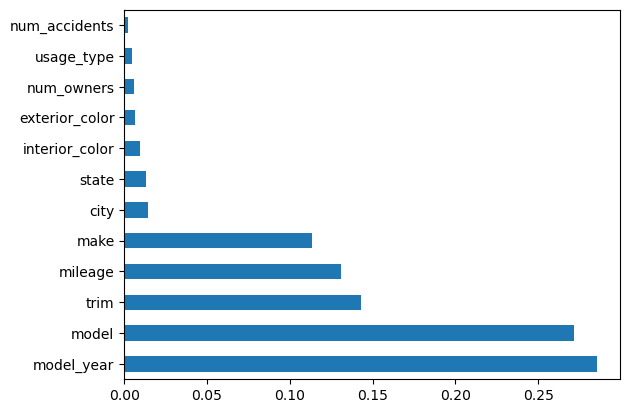

In [22]:
import matplotlib
feat_importances = pd.Series(used_car_predictor.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

#### **Step 5: Evaluate Model Performance**

In [23]:
make = ''
model = ''
trim = ''
exterior_color = ''
interior_color = ''
city = ''
state = ''
sqldf(f"SELECT DISTINCT make_y, model_y, trim_y, exterior_color_y, interior_color_y, city_y, state_y FROM merged_df WHERE make_x LIKE '%{make}%' AND model_x LIKE '%{model}%' OR exterior_color_x LIKE '%{exterior_color}%'")

make_y  model_y  trim_y  exterior_color_y  interior_color_y  city_y   
0           2      512    3181                 8                10     482  \
1           2      257    3905                 1                 1     482   
2           2      258    1109                 3                 1     529   
3           2      512    3182                 3                 1     131   
4           2      486    4955                 5                 0      46   
...       ...      ...     ...               ...               ...     ...   
69110       2      490     604                 3                 1     112   
69111      13      312    2355                 8                 4     267   
69112       5      417    2100                 5                 1     159   
69113      18      276    4004                 6                 1     368   
69114      12      329    1122                 0                 4     471   

       state_y  
0            2  
1            2  
2            7  
3            4  
4           37  
...        ...  
69110        4  
69111        4  
69112        4  
69113        3  
69114       38  

[69115 rows x 7 columns]

In [24]:
print(f'R-squared: {round(used_car_predictor.score(X, y), 4)}')
print(f'Max Depth: {used_car_predictor.get_depth()}')
print(f'Prediciton Output: ${used_car_predictor.predict([[2016, 23, 124, 171, 96080, 1, 1, 1, 2, 2, 365, 37]])[0]}')

R-squared: 0.9585
Max Depth: 39
Prediciton Output: $13599.0


In [26]:


predicted_price = used_car_predictor.predict([[2005, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])[0]
predicted_price

67689.0

In [ ]:
sqldf('SELECT MAX(num_owners_x) FROM merged_df')

MAX(num_owners_x)
0                  9